# Processing multispectral satellite images with Python

The goal of this short tutorial is to get familiar with Sentinel-2 data (spatial / spectral resolutions, georeferencing...). You will use the [rasterio](https://rasterio.readthedocs.io/en/latest/) library to read and process the Sentinel-2 images. Rasterio is a very useful library made to access geospatial raster (=image) data, often stored in a [GeoTIFF](https://en.wikipedia.org/wiki/GeoTIFF) format (a [TIFF](https://en.wikipedia.org/wiki/TIFF) format with georeferencing information).

Sentinel-2 data is stored and distributed into tiles which are 109.8 km × 109.8 km subdivisions of the [UTM grid](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) (see [here](https://hls.gsfc.nasa.gov/products-description/tiling-system/) for further details). In the `S2_SUBSET` folder, you will find a subset of one Sentinel-2 tile over Provence-Alpes-Côte-d’Azur, downloaded from the [GEODES](https://geodes.cnes.fr/en/homepage/) portal. There are many different portals (e.g. [Copernicus Browser](https://browser.dataspace.copernicus.eu/)) to access data of the Copernicus program, that may distribute slightly different products (pre-processed with different algorithms). To my knowledge, every portal provides different levels of products, that correspond to different steps of pre-processing. The two main levels are L1C (top-of-atmosphere reflectance data), and L2A (bottom-of-atmosphere reflectance data).

In the following, we will pre-process and store the L2A Sentinel-2 data into a Numpy ndarray / PyTorch tensor, such that we can apply signal processing / machine learning algorithms. Note that the [S2-Agri Pixel-Set](https://zenodo.org/records/5815488) data set used in Tutorial 1 has probably been created with the Rasterio library.

In [1]:
import os
import urllib.request

import matplotlib.pyplot as plt
import seaborn as sns

import rasterio
from rasterio.enums import Resampling

import pandas as pd
import numpy as np

from typing import Optional, Tuple, List

First, note that Sentinel-2 data is provided in different files: one for each spectral channel. FRE stands for Flat REflectance: this is reflectance data that has been corrected for atmospheric effects, environmental effects, and slope effects. It is also possible to have SRE products, which stands for Surface REflectance, which have not been corrected from slope effects.

In [2]:
s2_folder = 'S2_SUBSET'
img_files = os.listdir(s2_folder)
img_files = sorted(img_files, key=lambda x: float(x.split('FRE_B')[-1].split('.')[0].replace('A', '.5')))
img_files

['SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B2.tif',
 'SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B3.tif',
 'SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B4.tif',
 'SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B5.tif',
 'SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B6.tif',
 'SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B7.tif',
 'SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B8.tif',
 'SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B8A.tif',
 'SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B11.tif',
 'SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B12.tif']

Each channel corresponds to a detector with a specific spectral sensitivity, described by the sensor spectral function response. Let's have a look at it!

In [3]:
s2_spectral_response_function_download_link = "https://sentiwiki.copernicus.eu/__attachments/1692737/COPE-GSEG-EOPG-TN-15-0007%20-%20Sentinel-2%20Spectral%20Response%20Functions%202024%20-%204.0.xlsx?inst-v=59ac1eb3-61c9-4626-b824-7509bfd7c905"
s2_spectral_response_function_file = "COPE-GSEG-EOPG-TN-15-0007 - Sentinel-2 Spectral Response Functions 2024 - 4.0.xlsx"

if s2_spectral_response_function_file not in os.listdir():
    urllib.request.urlretrieve(s2_spectral_response_function_download_link, s2_spectral_response_function_file)

Currently, there are 3 Sentinel-2 satellites: Sentinel-2A, Sentinel-2B, and Sentinel-2C. They have slightly different spectral function responses (SFR). Here, we will plot the Sentinel-2A SFR.

In [4]:
sfr = pd.DataFrame(pd.read_excel(s2_spectral_response_function_file, sheet_name="Spectral Responses (S2A)"))
sfr.head()

/home/romain/anaconda3/envs/ml/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,SR_WL,S2A_SR_AV_B1,S2A_SR_AV_B2,S2A_SR_AV_B3,S2A_SR_AV_B4,S2A_SR_AV_B5,S2A_SR_AV_B6,S2A_SR_AV_B7,S2A_SR_AV_B8,S2A_SR_AV_B8A,S2A_SR_AV_B9,S2A_SR_AV_B10,S2A_SR_AV_B11,S2A_SR_AV_B12
0,300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


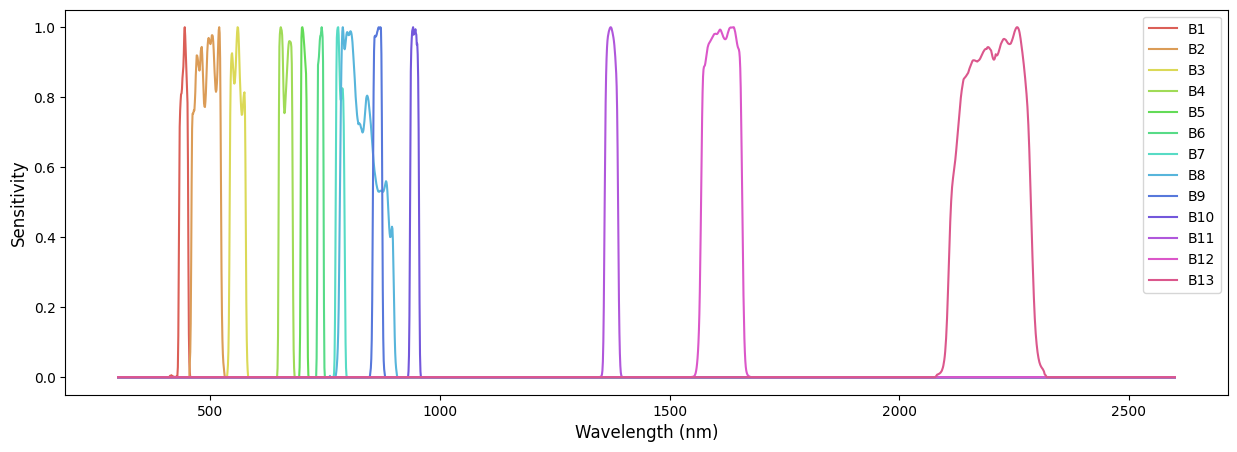

In [5]:
sfr = sfr.to_numpy()
wv, sfr = sfr[:, 0], sfr[:, 1:]

fig, ax = plt.subplots(figsize=(15, 5))
colors = sns.color_palette("hls", sfr.shape[1])
fontsize = 12
for band in range(sfr.shape[1]):
    plt.plot(wv, sfr[:, band], color=colors[band], label=f'B{band+1}')
plt.legend()
plt.xlabel('Wavelength (nm)', fontsize=fontsize)
plt.ylabel('Sensitivity', fontsize=fontsize)
# plt.savefig("s2_sfr.pdf", dpi=100, bbox_inches='tight', pad_inches=0.05)
plt.show()

Second, let's look at the spatial resolution.

In [6]:
for file in img_files:
    band = rasterio.open(os.path.join(s2_folder, file))
    print(file, band.shape)

SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B2.tif (1508, 1768)
SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B3.tif (1508, 1768)
SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B4.tif (1508, 1768)
SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B5.tif (754, 883)
SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B6.tif (754, 883)
SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B7.tif (754, 883)
SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B8.tif (1508, 1768)
SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B8A.tif (754, 883)
SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B11.tif (754, 883)
SUBSET_SENTINEL2C_20250730-104911-712_L2A_T31TFJ_C_V4-0_FRE_B12.tif (754, 883)


From the shape of the rasters, we can only deduce that B5, B6, B7, B81, B11 and B12 have a two times coarser resolution than B2, B3, B4 and B8. The spatial resolution of the rasters is provided in the metadata of the GeoTIFF.


Besides, note that B1 and B9 are not included in the L2A product (there are only used for the atmospheric correction).

Let's print the metadata of the B12 raster.

In [7]:
print('Image width: ', band.width)
print('Image height: ', band.height)
print('Number of channels: ', band.count, '\n')
    
print('Spatial bounding box: ', band.bounds)
print(f"The image covers the world from {band.bounds[0]} meters to {band.bounds[2]} meters,\
 left to right, and {band.bounds[1]} meters to {band.bounds[3]} meters, bottom to top.\n")

width_km = (band.bounds[2]-band.bounds[0]) / 1000
height_km = (band.bounds[3]-band.bounds[1]) / 1000
print(f"It covers a region {width_km} kilometers wide by {height_km} kilometers high.\n")

x_res = width_km / band.width * 1000
y_res = height_km / band.height * 1000
print(f'Spatial resolution: {x_res} m x {y_res} m.\n')

print('Affine transformation matrix:')
print(band.transform)

print('\nCoordinate reference system: ', band.crs)

Image width:  883
Image height:  754
Number of channels:  1 

Spatial bounding box:  BoundingBox(left=611440.0, bottom=4801160.0, right=629100.0, top=4816240.0)
The image covers the world from 611440.0 meters to 629100.0 meters, left to right, and 4801160.0 meters to 4816240.0 meters, bottom to top.

It covers a region 17.66 kilometers wide by 15.08 kilometers high.

Spatial resolution: 20.0 m x 20.0 m.

Affine transformation matrix:
| 20.00, 0.00, 611440.00|
| 0.00,-20.00, 4816240.00|
| 0.00, 0.00, 1.00|

Coordinate reference system:  EPSG:32631


From [rasterio's documentation](https://rasterio.readthedocs.io/en/latest), the "affine transformation matrix [...] maps pixel locations in (col, row) coordinates to (x, y) spatial positions. The product of this matrix and (0, 0), the column and row coordinates of the upper left corner of the dataset, is the spatial position of the upper left corner."

The coordinate values of the affine transformation are relative to the origin of the dataset’s coordinate reference system (CRS).

So, Sentinel-2 has either a 10m or 20m resolution. Let's resample the 20m bands to 10m, and concatenate every bands in a ndarray.

In [8]:
b2_shape = rasterio.open(os.path.join(s2_folder, img_files[0])).shape
s2_bands = []
for file in img_files:
    band = rasterio.open(os.path.join(s2_folder, file))    
    if band.shape[0] < b2_shape[0]:
        data = band.read(
            out_shape=(1, b2_shape[0], b2_shape[1]),
            resampling=Resampling.bilinear
        )
    else:
        data = band.read()
    s2_bands.append(data)
s2_img = np.concatenate(s2_bands, axis=0)
s2_img.shape

(10, 1508, 1768)

Note that geospatial raster data can be very large. Rasterio allows to open (`rasterio.open(file_path)`)a raster without loading the whole data. Then, you could use a rasterio [Window](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html) to only read a subset of the raster.

In [9]:
def rgb_render(
    data: np.ndarray,
    clip: int = 2,
    bands: Optional[List[int]] = None,
    norm: bool = True,
    dmin: Optional[np.ndarray] = None,
    dmax: Optional[np.ndarray] = None
) -> Tuple[np.ndarray, Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Prepare data for visualization with matplot lib, taken (with minor modifications) from the sensorsio repo by Julien Michel
    Source: https://framagit.org/jmichel-otb/sensorsio/-/blob/master/src/sensorsio/utils.py?ref_type=heads
    License: Apache License, Version 2.0
    
    :param data: nd_array of shape [bands, w, h]
    :param clip: clip percentile (between 0 and 100). Ignored if norm is False
    :bands: List of bands to extract (len is 1 or 3 for RGB)
    :norm: If true, clip a percentile at each end

    :returns: a tuple of data ready for matplotlib, dmin, dmax
    """
    if bands is None:
        bands = [2, 1, 0]
    assert len(bands) == 1 or len(bands) == 3
    assert 0 <= clip <= 100

    # Extract bands from data
    data_ready = np.take(data, bands, axis=0)
    out_dmin = None
    out_dmax = None
    # If normalization is on
    if norm:
        # Rescale and clip data according to percentile
        if dmin is None:
            out_dmin = np.percentile(data_ready, clip, axis=(1, 2))
        else:
            out_dmin = dmin
        if dmax is None:
            out_dmax = np.percentile(data_ready, 100 - clip, axis=(1, 2))
        else:
            out_dmax = dmax
        data_ready = np.clip((data_ready.transpose(1, 2, 0) - out_dmin) / (out_dmax - out_dmin), 0, 1)

    else:
        data_ready.transpose(1, 2, 0)

    # Strip of one dimension if number of bands is 1
    if data_ready.shape[-1] == 1:
        data_ready = data_ready[:, :, 0]

    return data_ready, out_dmin, out_dmax

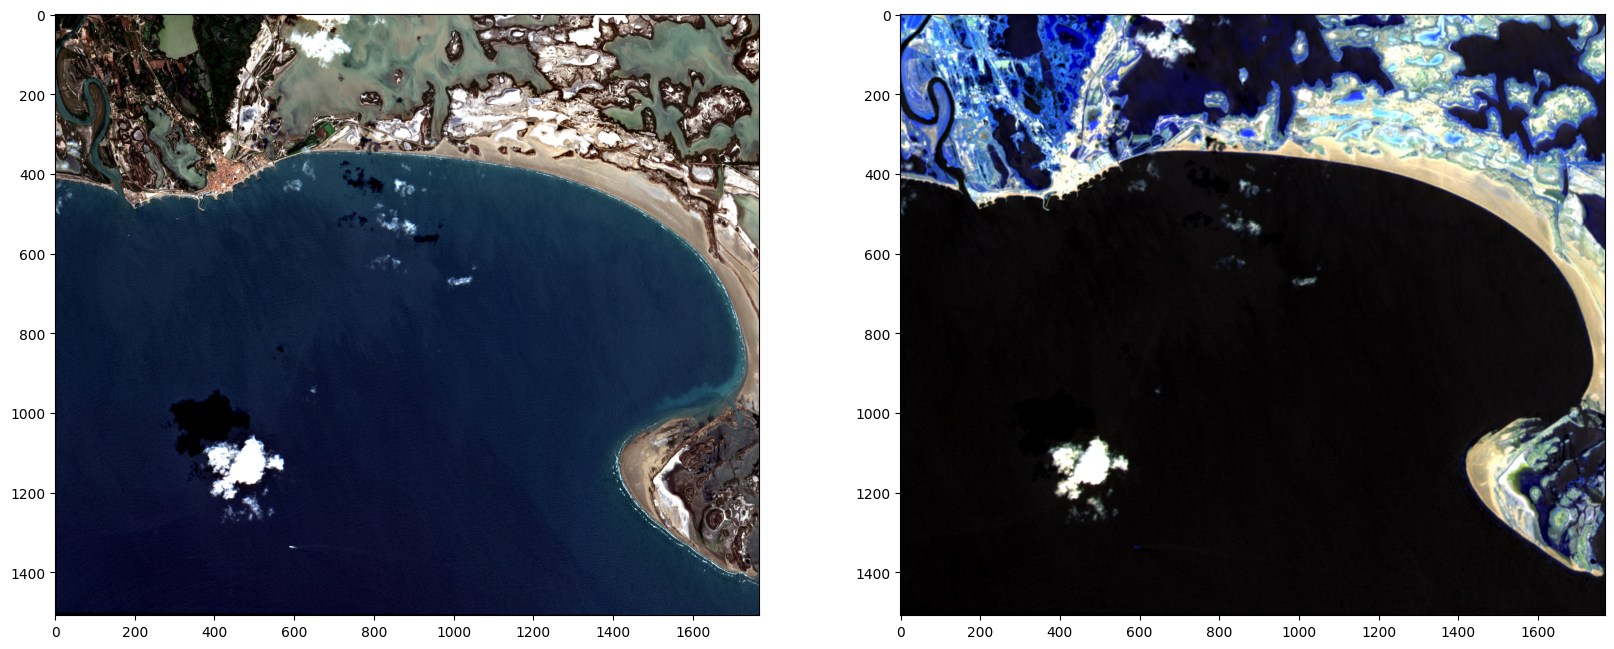

In [10]:
rgb, _, _ = rgb_render(s2_img)
swir_nir, _, _ = rgb_render(s2_img, bands=[9, 8, 7])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb)
ax[1].imshow(swir_nir)
plt.show()

Finally, let's have a look to the range of reflectance data (the L2A level provides bottom-of-atmosphere reflectance data).

In [16]:
print("Min value: ", s2_img.min())
print("Max value: ", s2_img.max())
print("Type: ", s2_img.dtype)

Min value:  0
Max value:  8932
Type:  int16


Data is stored in 16-bit values. In order to get reflectance values, it must be divided by a quantification value. For L2A Sentinel-2 images, the quantification value is equal to 10000.

In [20]:
s2_img_ref = s2_img / 10000

In [21]:
print("Min value: ", s2_img_ref.min())
print("Max value: ", s2_img_ref.max())

Min value:  0.0
Max value:  0.8932


Note that the maximum reflectance here is lower than one, which is often the case, but not always: https://www.cesbio.cnrs.fr/multitemp/16885-2/